# Assignment 9
## Nakiyah Dhariwala

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nakiyah24/ExplainableAI_Assignments/blob/main/Assignment9/Assignment9.ipynb)

### Introduction

What is a DNA?

- DNA, or Deoxyribonucleic Acid, is the molecule that carries the genetic instructions responsible for the growth, development, and functioning of all living organisms. Simply, it acts like a codebook containing instructions for building and maintaining life. 

Structurally, DNA is composed of two complementary strands twisted into a double helix. Each strand is made up of units called nucleotides, and each nucleotide contains one of four bases:

- Adenine (A)
- Thymine (T)
- Cytosine (C)
- Guanine (G)

These bases form specific pairs:
- A always pairs with T, and 
- C always pairs with G

### Goal

The goal of this project is to train a small neural network to learn the reverse-complement transformation of DNA sequences.
- Given an input DNA strand (e.g., A T G C A), the model must output its reverse complement (T G C A T).

To do this, the model needs to learn two simple rules:
1. Complement rule: match each base with its pair (A <-> T and C <-> G).
2. Reversal rule: flip the order of the sequence.

Though these rules are pretty simple intuitively, they will make the model think in two steps — first about what each base should become, and then where it should go.
That’s why I think this task is great for my mechanistic interpretability assignment, since we can open up the model and see which neurons learned to handle the base-pairing and which ones focus on the order of the sequence. Plus, I think using DNA makes for a fun, concrete analogy for a sequence-to-sequence modeling task.

To make this task suitable for a neural network, each base will be numerically encoded as shown below:
A = 0, T = 1, G = 2, C = 3.

For the neural network, I am going to build a very tiny LSTM model that reads the input sequence one base at a time and then predicts the entire reverse-complement sequence at the output. Because the model is so small, we can carefully inspect its hidden state activations and individual neurons to see how it learns these two rules, not just whether it gets the right answer. I’m specifically choosing an LSTM because I’ve used it before for prediction tasks, and I’m honestly just curious to see what it’s doing under the hood on a really simple problem like this. It feels like a good chance to finally peek inside instead of treating it like a black box.

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


def set_seed(seed=0):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


set_seed(42)

## Part 1 - Setup

In [ ]:
# Define DNA bases and complements
bases = ["A", "T", "G", "C"]
complement = {"A": "T", "T": "A", "C": "G", "G": "C"}


# Function to create random DNA sequence
def make_sequence(length=6):
    return [random.choice(bases) for _ in range(length)]


# Function to get reverse complement
def reverse_complement(seq):
    comp = [complement[b] for b in seq]
    return comp[::-1]  # reverse the complemented sequence


# Generate data
for i in range(5):
    seq = make_sequence()
    rc = reverse_complement(seq)
    print(f"Input : {' '.join(seq)}")
    print(f"Output: {' '.join(rc)}\n")

# Map each base to a number
base_to_id = {
    "A": 0,
    "T": 1,
    "G": 2,
    "C": 3,
}

# Reverse map: number -> base (handy for later)
id_to_base = {v: k for k, v in base_to_id.items()}


# Create an encoding setup
def encode(seq):
    """Take ['A','T','G'] -> [0,1,2]"""
    return [base_to_id[b] for b in seq]


def decode(seq_ids):
    """Take [0,1,2] -> ['A','T','G']"""
    return [id_to_base[i] for i in seq_ids]


# Build synthetic dataset
def make_dataset(n_samples=20, length=6):
    inputs_bases = []
    targets_bases = []
    inputs_ids = []
    targets_ids = []

    for _ in range(n_samples):
        seq = make_sequence(length)
        rc = reverse_complement(seq)

        inputs_bases.append(seq)
        targets_bases.append(rc)

        inputs_ids.append(encode(seq))
        targets_ids.append(encode(rc))

    return inputs_bases, targets_bases, inputs_ids, targets_ids


inputs_bases, targets_bases, inputs_ids, targets_ids = make_dataset(
    n_samples=10000, length=6
)


# I used chatgpt-5 to create this code on 11/08/2025
# Prompt: Help me create synthetic DNA data that can be mapped to its reverse complement and help me encode it so I can use it for my LSTM model

Input : A A G T T T
Output: A A A C T T

Input : A A C A A A
Output: T T T G T T

Input : T T A T C T
Output: A G A T A A

Input : C G A T C G
Output: C G A T C G

Input : G T T G A A
Output: T T C A A C



#### Creating Features and targets

In [3]:
# Used Chatgpt-5 to generate the following codebase on11/08/2025 to create a small lstm model and run it for the synthetic DNA data created above.

In [4]:
# 1. Convert to PyTorch tensors
X = torch.tensor(inputs_ids, dtype=torch.long)  # shape: (N, seq_len)
Y = torch.tensor(targets_ids, dtype=torch.long)  # shape: (N, seq_len)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: torch.Size([10000, 6])
Y shape: torch.Size([10000, 6])


In [5]:
# 2. Train/Validation Split
num_samples = X.shape[0]
split = int(0.8 * num_samples)

X_train, X_val = X[:split], X[split:]
Y_train, Y_val = Y[:split], Y[split:]

In [6]:
# 3. Model Setup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# I am using a very minimal configuration
vocab_size = 4
embed_dim = 2
hidden_dim = 4

embedding = nn.Embedding(vocab_size, embed_dim)
lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
linear = nn.Linear(hidden_dim, vocab_size)

embedding = embedding.to(device)
lstm = lstm.to(device)
linear = linear.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    list(embedding.parameters()) + list(lstm.parameters()) + list(linear.parameters()),
    lr=1e-2,
)

Using device: cpu


In [7]:
# 4. Training the data
batch_size = 32
num_epochs = 50

for epoch in range(1, num_epochs + 1):
    permutation = torch.randperm(X_train.size(0))
    total_loss = 0.0
    total_tokens = 0

    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i : i + batch_size]
        x_batch = X_train[indices].to(device)
        y_batch = Y_train[indices].to(device)

        optimizer.zero_grad()

        # Forward pass
        emb = embedding(x_batch)
        hidden, _ = lstm(emb)
        logits = linear(hidden)

        B, L, V = logits.shape
        loss = criterion(logits.view(B * L, V), y_batch.view(B * L))
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * B * L
        total_tokens += B * L

    train_loss = total_loss / total_tokens

    # Validation
    with torch.no_grad():
        emb = embedding(X_val.to(device))
        hidden, _ = lstm(emb)
        logits = linear(hidden)
        B, L, V = logits.shape
        val_loss = criterion(logits.view(B * L, V), Y_val.view(B * L)).item()

    print(
        f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}"
    )

Epoch 01 | Train Loss: 1.3312 | Val Loss: 1.2309
Epoch 02 | Train Loss: 1.2174 | Val Loss: 1.1961
Epoch 03 | Train Loss: 1.1924 | Val Loss: 1.1637
Epoch 04 | Train Loss: 1.1431 | Val Loss: 1.1034
Epoch 05 | Train Loss: 1.1019 | Val Loss: 1.0788
Epoch 06 | Train Loss: 1.0795 | Val Loss: 1.0553
Epoch 07 | Train Loss: 1.0636 | Val Loss: 1.0449
Epoch 08 | Train Loss: 1.0488 | Val Loss: 1.0459
Epoch 09 | Train Loss: 1.0450 | Val Loss: 1.0475
Epoch 10 | Train Loss: 1.0448 | Val Loss: 1.0305
Epoch 11 | Train Loss: 1.0330 | Val Loss: 1.0195
Epoch 12 | Train Loss: 1.0294 | Val Loss: 1.0142
Epoch 13 | Train Loss: 1.0324 | Val Loss: 1.0097
Epoch 14 | Train Loss: 1.0227 | Val Loss: 1.0055
Epoch 15 | Train Loss: 1.0370 | Val Loss: 1.0069
Epoch 16 | Train Loss: 1.0189 | Val Loss: 1.0059
Epoch 17 | Train Loss: 1.0195 | Val Loss: 1.0005
Epoch 18 | Train Loss: 1.0178 | Val Loss: 1.0449
Epoch 19 | Train Loss: 1.0162 | Val Loss: 0.9978
Epoch 20 | Train Loss: 1.0169 | Val Loss: 1.1092
Epoch 21 | Train Los

In [ ]:
# 5. Testing a few predictions
with torch.no_grad():
    for i in range(5):
        x = X_val[i].unsqueeze(0).to(device)  # shape (1, seq_len)

        emb = embedding(x)
        hidden, _ = lstm(emb)
        logits = linear(hidden)
        preds = logits.argmax(dim=-1)[0].cpu().tolist()  # list of ints

        # Convert tensors to Python lists of ints
        input_ids = X_val[i].tolist()
        target_ids = Y_val[i].tolist()

        # Map ids -> bases
        input_bases = [id_to_base[j] for j in input_ids]
        target_bases = [id_to_base[j] for j in target_ids]
        pred_bases = [id_to_base[j] for j in preds]

        print(f"\nExample {i+1}:")
        print("Input        :", " ".join(input_bases))
        print("Target (true):", " ".join(target_bases))
        print("Predicted    :", " ".join(pred_bases))


Example 1:
Input        : G C C C A T
Target (true): A T G G G C
Predicted    : G G G C C C

Example 2:
Input        : T A C A A A
Target (true): T T T G T A
Predicted    : A C A C A A

Example 3:
Input        : T G G C G A
Target (true): T C G C C A
Predicted    : A C C A C A

Example 4:
Input        : C T C C T T
Target (true): A A G G A G
Predicted    : G G T G T G

Example 5:
Input        : T T T T C C
Target (true): G G A A A A
Predicted    : A C A A A A


## Part 2 – Explore

In [9]:
# Inspect model behavior
with torch.no_grad():
    sample_input = X_val[0].unsqueeze(0).to(device)
    emb = embedding(sample_input)
    hidden_states, (h_n, c_n) = lstm(emb)
    logits = linear(hidden_states)

print("Sample Input (token IDs):", sample_input)
print("\nHidden Activations:", hidden_states)
print("\nOutput Logits:", logits)

with torch.no_grad():
    predicted_ids = logits.argmax(dim=-1)[0].cpu().tolist()

input_ids = X_val[0].tolist()
target_ids = Y_val[0].tolist()
input_bases = [id_to_base[j] for j in input_ids]
target_bases = [id_to_base[j] for j in target_ids]
pred_bases = [id_to_base[j] for j in predicted_ids]

print("\nInput bases       :", " ".join(input_bases))
print("True reverse-comp :", " ".join(target_bases))
print("Predicted bases   :", " ".join(pred_bases))

Sample Input (token IDs): tensor([[2, 3, 3, 3, 0, 1]])

Hidden Activations: tensor([[[ 0.0087,  0.0165,  0.0428, -0.0999],
         [ 0.0094,  0.0270,  0.1273, -0.1794],
         [-0.0600,  0.0455,  0.2095, -0.2933],
         [-0.4036,  0.0548,  0.1949, -0.5020],
         [-0.8263,  0.0957,  0.0254, -0.9243],
         [-0.6141,  0.3244, -0.1563, -0.9498]]])

Output Logits: tensor([[[-0.1363, -0.1444,  0.0980,  0.0844],
         [-0.2140, -0.1524,  0.0938,  0.0377],
         [-0.3591, -0.2615,  0.1097,  0.0597],
         [-1.0061, -0.8617,  0.4876,  0.4943],
         [-2.8988, -2.8892,  1.9886,  2.3015],
         [-2.8162, -4.3247,  2.1024,  3.8002]]])

Input bases       : G C C C A T
True reverse-comp : A T G G G C
Predicted bases   : G G G C C C


## Part 3 - Explain

From the above output, we can see that the LSTM model correctly identifies the last base in the reverse-complement (C), and also gets one of the middle bases (G) right, but it struggles with the first couple of positions in the sequence. This makes sense given that I trained a very tiny model for interpretability rather than maximum accuracy. 

Each row of the output logits refers to one position in the output sequence (thus 6 rows), and within a row the four numbers are `[logit_for_A, logit_for_T, logit_for_G, logit_for_C]`
Thus for row 1, 0.0980 is the highest activation at index 2, indicating that the model idetified G as the input. For row 2,the largest logit is 0.0938 at index 2, so the model still predicts G. Similarly, based on where the largest logit is located, the model predicts an output. 

In terms of hidden activations, we can see that each row represents the model internal state after reading that base. If we look at each neuron (each column) across time, it tells us what that neuron is tracking. For instance, Neuron 1 starts near 0 and then becomes increasingly negative as the model processes more bases could indicate that the neuron is tracking how long the sequence has gone on for. In contrast, neuron 2 slowly increases the more bases it sees. It could be noticing a repeating pattern or getting more “activated” as the model becomes more certain about what it’s reading. Neuron 3 increases and then drops halfway, meaning it reacted strongly to something in the middle. Lastly, neuron 4 get more negtive as the sequence continues. It is stronger than neuron 1 and hence might be signaling that the sequence is almost finished or turning down certain outputs near the end

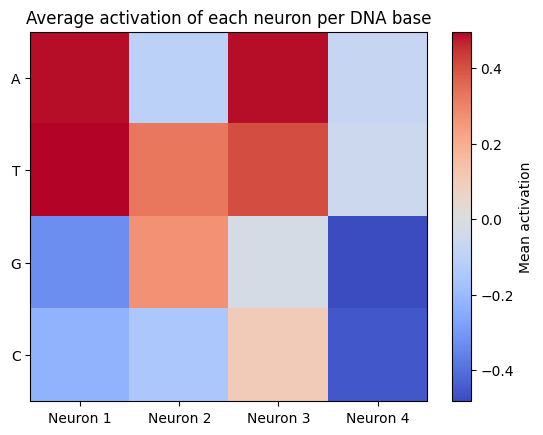

In [10]:
# Look at average activations per base for the 4 neurons
avg_acts = []

with torch.no_grad():
    for name in ["A", "T", "G", "C"]:
        x = torch.full((1, 6), base_to_id[name], dtype=torch.long).to(device)
        emb = embedding(x)
        h, _ = lstm(emb)
        avg_acts.append(h.mean(dim=1).squeeze().cpu().numpy())

# Convert list → NumPy → Torch (avoids warning)
avg_acts = np.stack(avg_acts)

plt.imshow(avg_acts, cmap="coolwarm", aspect="auto")
plt.colorbar(label="Mean activation")
plt.xticks([0, 1, 2, 3], ["Neuron 1", "Neuron 2", "Neuron 3", "Neuron 4"])
plt.yticks(range(4), ["A", "T", "G", "C"])
plt.title("Average activation of each neuron per DNA base")
plt.show()

THrough this heatmap, we can see that that each row represents one DNA base while the columns are each of the four hidden LSTM neurons. On the whole, this heatmap shows the average activation of each hidden neuron for each DNA base. 

Based on the shades, I can see that: 
- Neuron 1 shows strong positive activation for A and T and negative activation for G and C which suggests that it can dstinguish betweeen A/T and G/C by activating or A/T. 
- Neuron 2 reacts mildly to T and G meaning it is sensitive to those two bases specifically.
- Neuron 3 responds highly to A and T, with slightly positive values for C, showing a milder pattern.

Neuron 4 stays mostly blue across all bases, which could mean thtat it is consistently unused or suppressed.
Maybe it tracks broader sequence context such as position in the strand of how far along it is in the 6-base sequence so it can reverse the order correctly at output time.

To test whether any neurons do track position within the DNA sequence rather than base identity, I shall look at how each neuron’s average activation changes across sequence positions for many random DNA samples.

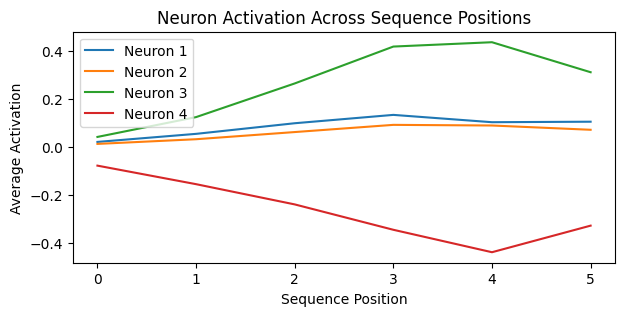

In [11]:
# looking at how each neuron activates over positions for random sequences
n_sequences = 200
seq_len = X_val.shape[1]
hidden_dim = lstm.hidden_size

pos_acts = torch.zeros((hidden_dim, seq_len))

with torch.no_grad():
    for _ in range(n_sequences):
        # make a random DNA sequence
        x = torch.randint(0, 4, (1, seq_len)).to(device)
        emb = embedding(x)
        h, _ = lstm(emb)
        pos_acts += h.squeeze(0).T  # shape: (hidden_dim, seq_len)

pos_acts /= n_sequences
pos_acts = pos_acts.cpu().numpy()

plt.figure(figsize=(7, 3))
for i in range(hidden_dim):
    plt.plot(range(seq_len), pos_acts[i], label=f"Neuron {i+1}")
plt.xlabel("Sequence Position")
plt.ylabel("Average Activation")
plt.title("Neuron Activation Across Sequence Positions")
plt.legend()
plt.show()

This line plot shows how each neuron’s average activation changes across sequence positions (from left to right along the 6-base DNA sequence).

- Neuron 1 and Neuron 2 stay close to zero
- Both Neuron 3 and Neuron 4 show a clear trend across sequence positions which I think means both are encoding some information about position.
    - Neuron 3 shows a strong, increasing trend across the sequence, suggesting it builds up activation as the model reads more bases. This likely helps the model keep track of how far along it is and provides a clear positional signal that supports reversing the sequence correctly.
    - Neuron 4 also changes with position but it decreases rather than increases, suggesting it might be playing a balancing or inhibitory role rather than directly signaling position for the LSTM.

## Part 4 - Reflection

This assignment helped me understand what’s actually happening inside an LSTM. I’ve always thought of LSTMs as a complete black box when I used it in the past to predict stock prices and cryptocurrency prices, but breaking things down to a tiny one-layer model made it feel much less opaque. Once I plotted the activations, I could actually see which neurons were doing something meaningful instead of just staring at numbers.

However, it did take some time to understand what the activations meant in context. Heatmaps and line plots made it easier, but interpreting any of this without visuals would’ve been really hard. I was also a little surprised that even such a small model still formed clear patterns, like the neuron that steadily increased across the sequence.

If I had more time, I’d want to see how this changes with two or three layers. Though understanding one layer feels pretty straightforwrd,  I wonder how much more complicated it would get with more than one layer and whether the neurons stay interpretable or just get tangled.

References:

- Dr. Brinnae Bent's atarter codebook
- GPT-5 for the code
- https://www.cancer.gov/publications/dictionaries/genetics-dictionary/def/dna
